# Closing Credit Recognizer Feasability

Within this notebook I explore the feasability of the idea to see if using convolutional we can classify frames into classes of Movie Screenshot and Closing Credit.

At this stage you should have the dataset in place in separate directories, we first create directories for training and validation data and break the dataset into training and validation before training the models.

In [28]:
import shutil, os
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras import layers, models, optimizers
from pathlib import Path

data_path = Path('../data/')
directories = ['closing_credits', 'movie_screenshot']

data_path = Path('../data/')
dataset_path = data_path/'dataset'
train = dataset_path/'train'
valid = dataset_path/'valid'

for directory in directories:
    train_path = train/directory
    train_path.mkdir(parents=True, exist_ok=True)
    valid_path = valid/directory
    valid_path.mkdir(parents=True, exist_ok=True)

### Run this block of code only once to randomly break the images into training and validation and move them to the corresponding directory

In [29]:
for directory in directories:
    fnames = sorted(os.listdir(dataset_path/directory))
    fnames = [fname for fname in fnames if fname[-4] == '.' or fname[-5] == '.']
    indices = np.arange(len(fnames), dtype=np.int16)
    np.random.shuffle(fnames)
    train_path = train/directory
    valid_path = valid/directory
    break_point = int(len(fnames) * 0.2)
    for fname in fnames[:break_point]:
        shutil.copyfile(dataset_path/directory/fname, valid_path/fname)
    for fname in fnames[break_point:]:
        shutil.copyfile(dataset_path/directory/fname, train_path/fname)

### Assessing the idea using an arbitrary CNN

For the first attempt I created a simple arbitrary Convolutional Neural Network to see if it can differentiate between classes.

In [30]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

### Creating the data generators

In order to feed the data to our network we have to create Keras Data Generators. No data augmentation at this point is done. We only normalise the values to be between 0 and 1. There are 400 training examples and 100 for validation.

In [31]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train,
        target_size=(224, 224),
        batch_size=40,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        valid,
        target_size=(224, 224),
        batch_size=25,
        class_mode='binary')

Found 400 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


### Training the first model

Finally, model is being trained in the following code block and we save it on the disk.

In [32]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=10,
      epochs=35,
      validation_data=validation_generator,
      validation_steps=4)

model.save('closing_credits_simple_CNN.h5')

c:\PVSPYH21\LIA1\closing-credits-recognizer\env\lib\site-packages\ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/35
10/10 [==============================] - 16s 1s/step - loss: 0.7168 - acc: 0.6250 - val_loss: 0.6283 - val_acc: 0.7700
Epoch 2/35
10/10 [==============================] - 14s 1s/step - loss: 0.5337 - acc: 0.7175 - val_loss: 0.6080 - val_acc: 0.7400
Epoch 3/35
10/10 [==============================] - 15s 2s/step - loss: 0.4682 - acc: 0.7850 - val_loss: 0.5332 - val_acc: 0.8000
Epoch 4/35
10/10 [==============================] - 14s 1s/step - loss: 0.4494 - acc: 0.7875 - val_loss: 0.5023 - val_acc: 0.8400
Epoch 5/35
10/10 [==============================] - 14s 1s/step - loss: 0.4525 - acc: 0.8050 - val_loss: 0.4966 - val_acc: 0.8500
Epoch 6/35
10/10 [==============================] - 15s 1s/step - loss: 0.3909 - acc: 0.8375 - val_loss: 0.4661 - val_acc: 0.8700
Epoch 7/35
10/10 [==============================] - 13s 1s/step - loss: 0.3955 - acc: 0.8425 - val_loss: 0.4585 - val_acc: 0.8100
Epoch 8/35
10/10 [==============================] - 13s 1s/step - loss: 0.3723 - acc: 0.86

### Plotting training and validation's accuracy and loss

It can be observed that model is doing very well already! Achieving an accuracy above 0.90 and no sign of overfitting. Given this result it can be said that we can use such a model for our purposes, and so it is feasable.

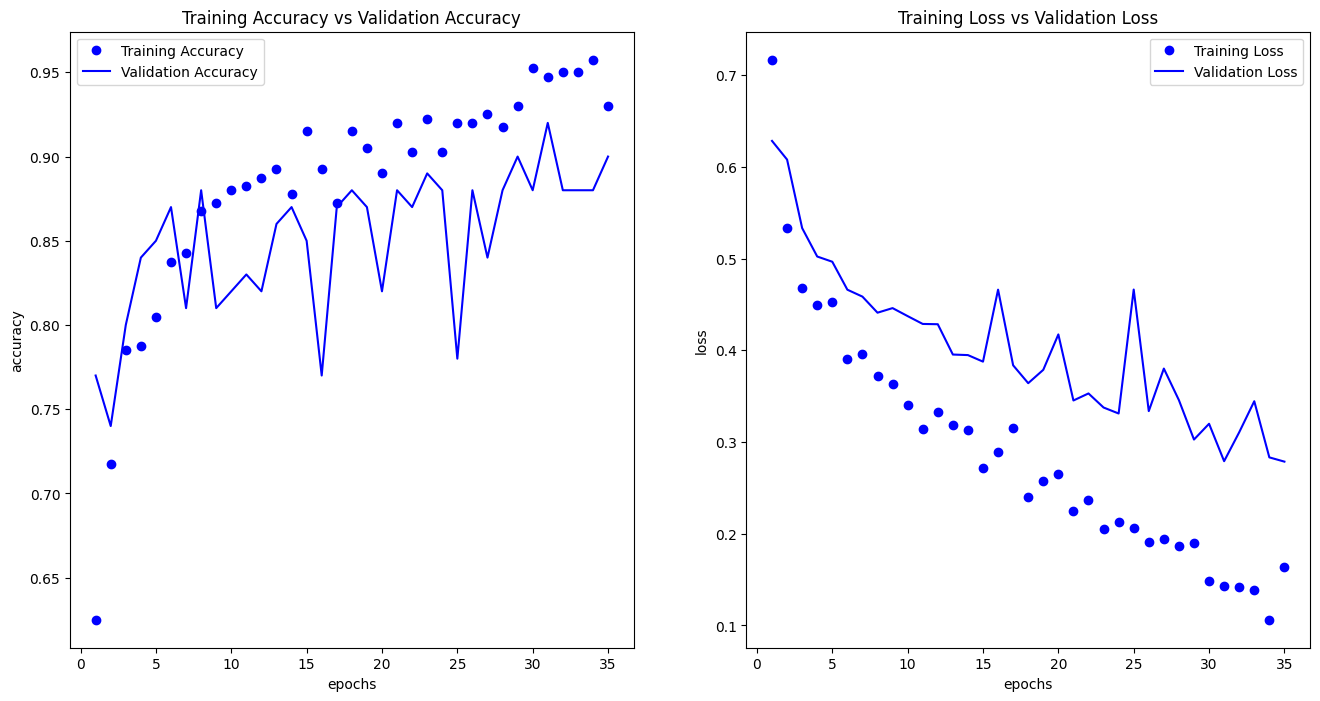

In [33]:
def plot_train_vs_valid(history):
    acc = history.history['acc']
    loss = history.history['loss']
    val_acc = history.history['val_acc']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc)+1)
    fig = plt.figure()
    fig.set_figheight(8)
    fig.set_figwidth(16)
    ax = fig.add_subplot(1,2,1)
    ax.plot(epochs, acc, 'bo', label='Training Accuracy')
    ax.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    ax.set_title('Training Accuracy vs Validation Accuracy')
    ax.set_xlabel('epochs')
    ax.set_ylabel('accuracy')
    ax.legend()
    ax = fig.add_subplot(1,2,2)
    ax.plot(epochs, loss, 'bo', label='Training Loss')
    ax.plot(epochs, val_loss, 'b', label='Validation Loss')
    ax.set_title('Training Loss vs Validation Loss')
    ax.set_xlabel('epochs')
    ax.set_ylabel('loss')
    ax.legend()
    plt.show()
    
plot_train_vs_valid(history)

### Transfer Learning Using ResNet50

Now that we have reached the conclusion that it's possible to differentiate between rolling credits and snapshots of movies let's try out a pretrained ResNet50 model to check what would happen.

In [34]:
from keras.applications import ResNet50

In [35]:
conv_base = ResNet50(weights='imagenet',
                     include_top=False,
                     input_shape=(224, 224, 3))

conv_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [36]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

### Freezing the layers except the last ones

Here I have freezed all the layers except the last 35 layers to disable weights getting updated during training.

In [37]:
conv_base.trainable = True

for layer in conv_base.layers:
    layer.trainable = False
for layer in conv_base.layers[-35:]:
    layer.trainable = True

In [38]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=10,
      epochs=10,
      validation_data=validation_generator,
      validation_steps=4)

c:\PVSPYH21\LIA1\closing-credits-recognizer\env\lib\site-packages\ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/10
10/10 [==============================] - 42s 4s/step - loss: 2.1294 - acc: 0.6950 - val_loss: 0.6334 - val_acc: 0.6300
Epoch 2/10
10/10 [==============================] - 35s 4s/step - loss: 0.1670 - acc: 0.9300 - val_loss: 0.6077 - val_acc: 0.7200
Epoch 3/10
10/10 [==============================] - 35s 3s/step - loss: 0.1111 - acc: 0.9575 - val_loss: 0.5763 - val_acc: 0.7600
Epoch 4/10
10/10 [==============================] - 35s 3s/step - loss: 0.0762 - acc: 0.9700 - val_loss: 1.0483 - val_acc: 0.5200
Epoch 5/10
10/10 [==============================] - 35s 3s/step - loss: 0.2824 - acc: 0.9075 - val_loss: 0.5501 - val_acc: 0.6900
Epoch 6/10
10/10 [==============================] - 34s 3s/step - loss: 0.0346 - acc: 0.9850 - val_loss: 0.5305 - val_acc: 0.7200
Epoch 7/10
10/10 [==============================] - 35s 3s/step - loss: 0.3300 - acc: 0.9150 - val_loss: 0.5229 - val_acc: 0.7200
Epoch 8/10
10/10 [==============================] - 35s 4s/step - loss: 0.0653 - acc: 0.97

### Result

And huge success! It took one epoch to achieve 0.99 accuracy! Therefore, here we save this model to be used for the actual service.

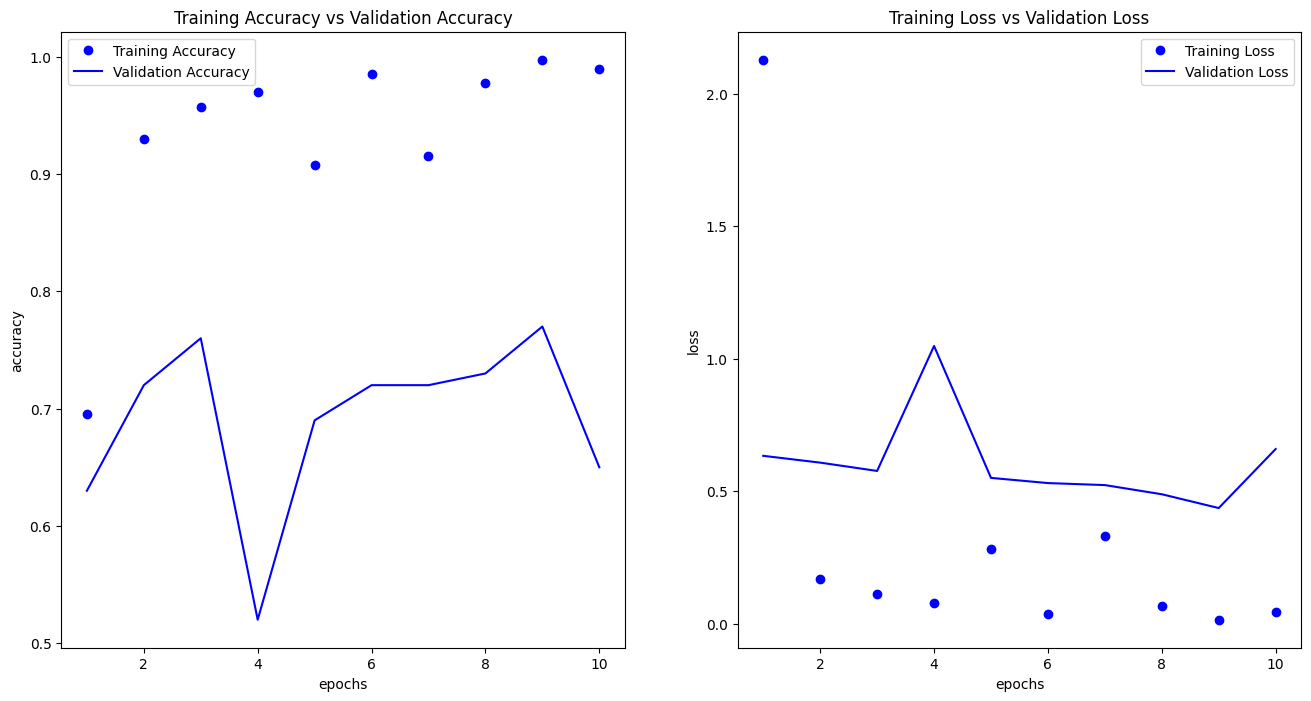

In [39]:
model.save('closing_credits_Resnet50.h5')

plot_train_vs_valid(history)